## Curve fitting
We have a regression problem on a time series with multiple dimensions. Given the nature of this problem (other stock prediction models) the best approach might be a seq2seq model. <br>
**Advantages**
<il>
<ol>Big amounts of data/ </ol>
<ol>Not a lot of features, but they seem to be descriptive. </ol>
<ol>Antecedents are succesful .. **on datasets tough** </ol>
</il>

**Disadvantages**
<il>
<ol>Not enough dimensions for a serious model.</ol>
<ol>High non-linearities in small gaps of time. </ol>
<ol>Smoothing migth look good, but we need to predict in small gaps of time.</ol>
<ol>MSE is a good metric?</ol>
</il>


In [1]:
# Libraries
import os
import sys
# Data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# ML stuff
#import tensorflow as tf

## 1. Data wrangling

### Get data

In [2]:
df_raw = pd.read_excel("data/data_reduced_datetime_processed.xlsx")

In [3]:
df_raw.head()

,Close,High,Low,Open,Volume_(BTC),Volume_(Currency),Weighted_Price,day,hour,minute,month,year
0,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,31,3,52,12,2011
1,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,31,4,22,12,2011
2,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,31,4,52,12,2011
3,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,31,5,22,12,2011
4,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,31,5,52,12,2011


### Clean data
Nan values were cleared in the re-sampling notebook. So, the data is free of outliers.

In [4]:
# Get only useful features
df = df_raw.drop(["Open", "Close", "High", "Low", "day", "hour", "minute", "month"], axis = 1)
print(df.shape)
df.head()

(101529, 4)


,Volume_(BTC),Volume_(Currency),Weighted_Price,year
0,0.455581,2.0,4.39,2011
1,0.455581,2.0,4.39,2011
2,0.455581,2.0,4.39,2011
3,0.455581,2.0,4.39,2011
4,0.455581,2.0,4.39,2011


In [23]:
# Data is not normalized
df.describe()

,Volume_(BTC),Volume_(Currency),Weighted_Price,year
count,101529.000000,1.015290e+05,101529.000000,101529.000000
mean,11.166317,5.493279e+03,589.201456,2014.410572
std,35.605275,2.426520e+04,882.907430,1.674544
min,0.000000,0.000000e+00,4.140000,2011.000000
25%,0.426050,6.224937e+01,101.340000,2013.000000
50%,2.000000,3.212688e+02,362.430000,2014.000000
75%,8.579310,2.104505e+03,631.878839,2016.000000
max,2251.989096,1.234686e+06,5845.752399,2017.000000


In [5]:
# Mean normalization
for feature in df.drop(["year"], axis = 1).columns:
    df[feature] = (df[feature] - df[feature].mean()) / df[feature].std() 
df.describe()

,Volume_(BTC),Volume_(Currency),Weighted_Price,year
count,1.015290e+05,1.015290e+05,1.015290e+05,101529.000000
mean,-2.715388e-17,8.957980e-18,1.254117e-16,2014.410572
std,1.000000e+00,1.000000e+00,1.000000e+00,1.674544
min,-3.136141e-01,-2.263851e-01,-6.626532e-01,2011.000000
25%,-3.016482e-01,-2.238197e-01,-5.525624e-01,2013.000000
50%,-2.574427e-01,-2.131452e-01,-2.568462e-01,2014.000000
75%,-7.265797e-02,-1.396558e-01,4.833732e-02,2016.000000
max,6.293514e+01,5.065660e+01,5.953683e+00,2017.000000


In [6]:
# Categorize year
print("Year values before catg: ", df["year"].unique())
df["year"] = df["year"].map({2011: 0, 2012: 1, 2013: 2, 2014: 3, 2015: 4, 2016: 5, 2017: 6})
print("Year values after catg", df["year"].unique())

Year values before catg:  [2011 2012 2013 2014 2015 2016 2017]
Year values after catg [0 1 2 3 4 5 6]


In [7]:
df.head()

,Volume_(BTC),Volume_(Currency),Weighted_Price,year
0,-0.300819,-0.226303,-0.66237,0
1,-0.300819,-0.226303,-0.66237,0
2,-0.300819,-0.226303,-0.66237,0
3,-0.300819,-0.226303,-0.66237,0
4,-0.300819,-0.226303,-0.66237,0


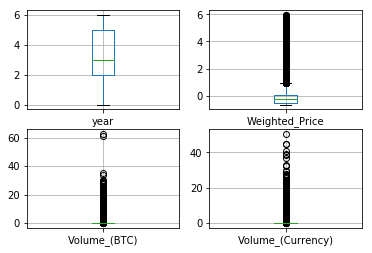

In [8]:
plt.subplot(2,2,1)
df.boxplot("year")
plt.subplot(2,2,2)
df.boxplot("Weighted_Price")
plt.subplot(2,2,3)
df.boxplot("Volume_(BTC)")
plt.subplot(2,2,4)
df.boxplot("Volume_(Currency)")
plt.show()

### Create dataset format
The model needs to look back for the next prediction. Therefore, let's make it look a certain amount N of data points. 

In [9]:
# Hyperparameter
data_points_to_look_back = 10

In [10]:
# Aux variables
start_idx = 0
end_idx = data_points_to_look_back
# Create the dataset
x_data = []
y_data = []
for i in range(data_points_to_look_back, df.shape[0]-100000):
    # Append data
    x_data.append(df["Weighted_Price"].iloc[start_idx:end_idx])
    y_data.append(df["Weighted_Price"].iloc[end_idx])
    # Update idxs
    start_idx += 1
    end_idx += 1

In [11]:
# Convert to numpy
x_data = np.array(x_data)
y_data = np.array(y_data)
# Feedback
print(x_data.shape, y_data.shape)

(1519, 10) (1519,)


Let's print some samples.

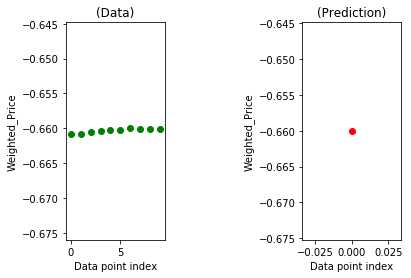

In [12]:
random_row = int(np.random.rand()*x_data.shape[0])

plt.subplot(1, 3, 1)
plt.scatter(list(range(x_data.shape[1])), x_data[random_row, :], color = "g")
plt.title("(Data)")
plt.xlabel("Data point index")
plt.ylabel("Weighted_Price")

plt.subplot(1, 3, 3)
plt.scatter([0], y_data[random_row], color = "r")
plt.title("(Prediction)")
plt.xlabel("Data point index")
plt.ylabel("Weighted_Price")
plt.show()

## 2. EDA (already done)

## 3. ML regression model

### Let's try a simple neural network
The neural network will look back until a certain point.

In [13]:
# Tensorflow
from tensorflow.python.framework import ops
# Own models
from tensorflowModelsForCryptotrading import *

# Create neural net instance
nn = VanillaNeuralNetwork(x = x_data,
                            y = y_data,
                            layers = 4,
                            neurons = [data_points_to_look_back, 20, 20, 1],
                            learningRate = 0.001,
                            epochs = 1000)

ModuleNotFoundError: No module named 'tensorflow'

## Conclussions